# Evaluation

Evaluate trainings of models ('model_names') on a set of datasets ('dataset_paths'). 
- Trained model weights loaded from 'models_save_dir'. 
- Results stored in 'results_dir'.

In [2]:
import os
import numpy as np
from tqdm import tqdm
import json
from matplotlib import pyplot as plt

from ekman_expressions.nets import getNetByName
from ekman_expressions.test import test_dir, plot_confusion_matrix, save_classification_report

In [3]:
# Models
model_names = ['SilNet', 'WeiNet', 'AlexNet', 'SongNet', 'InceptionV3',
               'VGG19', 'VGG16', 'ResNet50', 'ResNet101V2', 'Xception',
               'MobileNetV3Large', 'EfficientNetV2B0']

# Number of k-cross validations and folder where they are located
# Alternatively set the paths to the target training and test manually
K = 5
dataset_paths_root = '../datasets/'
dataset_paths_train = []
dataset_paths_test = []
for i in range(K):
    dataset_paths_train.append(dataset_paths_root + 'CV' + str(i+1))
    dataset_paths_test.append(dataset_paths_root + 'CV' + str(i+1) + '_test')

# Folder where the trained models were saved
models_save_dir = '../models'

# Folder where to save the evaluation results
results_dir = '../results'

# Labels of the classes
label_names = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise']

## Test results, Confussion Matrix and Classification report

In [ ]:
# Init progress bar
progress = tqdm(total=len(model_names)*len(dataset_paths_train))

for model_name in model_names:
    for train_path, test_path in zip(dataset_paths_train, dataset_paths_test):
        
        # Results foder
        results_net = os.path.join(results_dir, model_name + '_'
                                   + os.path.basename(train_path)
                                   + '_results')
        if not os.path.exists(results_net):
            os.mkdir(results_net)

        # Load model
        model, img_size = getNetByName(model_name)
        model_save_path = os.path.join(
            models_save_dir,
            model_name + '_' + os.path.basename(train_path) + '_weights.h5')
        model.load_weights(model_save_path)

        # Test
        test_file = os.path.join(results_net, 'test.json')
        test_dir(test_path, test_file, model, img_size)

        # Plot confusion matrix
        cm_path = os.path.join(results_net, 'confusion_matrix.png')
        plot_confusion_matrix(test_path, test_file, img_size, label_names, cm_path)

        # Save classification report
        cr_path = os.path.join(results_net, 'classification_report.json')
        save_classification_report(test_path, test_file, img_size, cr_path)

        # Update progress
        progress.update(1)

# Close progress
progress.close()

## K-Cross Validation Results

In [5]:
cv_means_acc = []
cv_means_pre = []
cv_means_rec = []
cv_means_f1s = []

for model_name in model_names:
    
    reports = []
    
    for train_path, test_path in zip(dataset_paths_train, dataset_paths_test):
        
        # Results foder and classification report file
        results_net = os.path.join(results_dir, model_name + '_' + os.path.basename(train_path) + '_results')
        cr_path = os.path.join(results_net, 'classification_report.json')
        
        # Load json file
        with open(cr_path, 'r') as f:
            reports.append(json.load(f))
    
    # Compute mean between CV test sets
    cv_means_acc.append(np.mean([x['accuracy'] for x in reports]))
    cv_means_pre.append(np.mean([x['macro avg']['precision'] for x in reports]))
    cv_means_rec.append(np.mean([x['macro avg']['recall'] for x in reports]))
    cv_means_f1s.append(np.mean([x['macro avg']['f1-score'] for x in reports]))

In [6]:
{model_name: {'accuracy': acc, 'precision': pre, 'recall': rec,'f1-score':  f1s} for model_name, acc, pre, rec, f1s in zip(model_names, cv_means_acc, cv_means_pre, cv_means_rec, cv_means_f1s)}

{'SilNet': {'accuracy': 0.818046192263273,
  'precision': 0.8187946967608575,
  'support': 0.7996563234187959,
  'f1-score': 0.8017675348878474},
 'WeiNet': {'accuracy': 0.8008199853907323,
  'precision': 0.7894557806700837,
  'support': 0.7796278055933018,
  'f1-score': 0.7799700665828592},
 'AlexNet': {'accuracy': 0.8449111764762403,
  'precision': 0.8372657905088386,
  'support': 0.8319561262401672,
  'f1-score': 0.8317623743441779},
 'SongNet': {'accuracy': 0.7990163448222148,
  'precision': 0.7953446313567606,
  'support': 0.7842546465017085,
  'f1-score': 0.7846394715807306},
 'InceptionV3': {'accuracy': 0.7965079000216901,
  'precision': 0.7946615372586308,
  'support': 0.7711537580678498,
  'f1-score': 0.772245403344509},
 'VGG19': {'accuracy': 0.8287991543638731,
  'precision': 0.8254929131149593,
  'support': 0.8074765997271435,
  'f1-score': 0.8109012676807147},
 'VGG16': {'accuracy': 0.8423086627920057,
  'precision': 0.8403208109277742,
  'support': 0.8276763577544038,
  '

## Plots

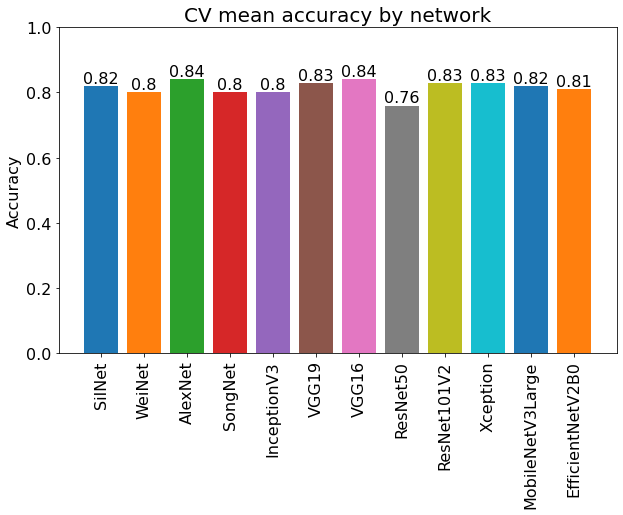

In [10]:
plt.figure(figsize=(10, 6))
plt.rc('font', size=16)
plt.title('CV mean accuracy by network', fontdict={'fontsize':20})
plt.xticks(rotation='vertical')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
for model_name, cv_mean_acc in zip(model_names, cv_means_acc):
    bar = plt.bar(model_name, round(cv_mean_acc, 2))
    plt.bar_label(bar)
plt.show()

In [ ]:
plt.title('CV Mean Precision')
plt.xticks(rotation='vertical')
plt.ylabel('Precision')
plt.ylim(0, 1)
for model_name, cv_mean_acc in zip(model_names, cv_means_pre):
    bar = plt.bar(model_name, round(cv_mean_acc, 2))
    plt.bar_label(bar)
plt.show()

In [ ]:
plt.title('CV Mean Recall')
plt.xticks(rotation='vertical')
plt.ylabel('Recall')
plt.ylim(0, 1)
for model_name, cv_mean_acc in zip(model_names, cv_means_rec):
    bar = plt.bar(model_name, round(cv_mean_acc, 2))
    plt.bar_label(bar)
plt.show()

In [ ]:
plt.title('CV Mean F1-score')
plt.xticks(rotation='vertical')
plt.ylabel('F1-score')
plt.ylim(0, 1)
for model_name, cv_mean_acc in zip(model_names, cv_means_f1s):
    bar = plt.bar(model_name, round(cv_mean_acc, 2))
    plt.bar_label(bar)
plt.show()